In [18]:
%matplotlib inline

In [19]:
import torch
from torch import nn, optim
from torchsummary import summary
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


Load the Cifar10 dataset

In [21]:
batch_size_train = 64
batch_size_test = 64

train_data = torchvision.datasets.CIFAR10(root = './data',
                                          train = True,
                                          download=True,
                                          transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.CIFAR10(root = './data',
                                          train = False,
                                          download=True,
                                          transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data,batch_size = batch_size_train, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, shuffle = True)
print(train_loader)

Files already downloaded and verified
Files already downloaded and verified


Create the model

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=(3,3), padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=(3,3), padding = 1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=(3,3), padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=(3,3), padding = 1)
        self.batchnorm2 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=(3,3), padding = 1)
        self.conv6 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=(3,3), padding = 1)
        self.conv7 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=(3,3), padding = 1)
        self.batchnorm3 = nn.BatchNorm2d(256)

        self.conv8 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=(3,3), padding = 1)
        self.conv9 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=(3,3), padding = 1)
        self.conv10 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = (3,3), padding = 1)
        self.batchnorm4 = nn.BatchNorm2d(512)

        # self.conv9 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size=(3,3), padding = 1)
        # self.conv10 = nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size=(3,3), padding = 1)
        # self.batchnorm5 = nn.BatchNorm2d(1024)

        self.avgpool = nn.AvgPool2d(kernel_size=(2,2), stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.linear1 = nn.LazyLinear(64, bias = True)
        self.dropout = nn.Dropout(p = 0.5)
        self.linear2 = nn.Linear(64, 10, bias = True)
        self.softmax = nn.Softmax(-1)

    def forward(self,x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.avgpool(x)
        x = self.batchnorm1(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.avgpool(x)
        x = self.batchnorm2(x)

        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.avgpool(x)
        x = self.batchnorm3(x)

        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.avgpool(x)
        x = self.batchnorm4(x)

        # x = self.relu(self.conv9(x))
        # x = self.relu(self.conv10(x))
        # x = self.maxpool(x)
        # x = self.batchnorm5(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return self.softmax(x)

model = CNN()
model.to(device)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         AvgPool2d-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        AvgPool2d-11            [-1, 128, 8, 8]               0
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

C:\Users\duyan\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Initialize hyperparamters

In [23]:
optimizer = optim.SGD(model.parameters(), momentum = 0.9, lr = 0.01, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
num_epochs = 200

Train the model

In [24]:
train_acc_list = []
val_acc_list = []

train_loss_list = []
val_loss_list = []

es_count = 0
curr_epoch = 0

for epoch in range(num_epochs):

    if es_count == 5:
        print("Stop training")
        curr_epoch = epoch
        break
    model.train()
    train_loss = 0
    train_acc = 0

    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
        train_acc += accuracy.item()

    train_acc /= len(train_loader)
    train_loss /= len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    model.eval()
    test_acc = 0
    test_loss = 0

    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            test_loss += loss.item()
            accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
            test_acc += accuracy.item()

        test_acc /= len(test_loader)
        test_loss /= len(test_loader)
        val_acc_list.append(test_acc)
        val_loss_list.append(test_loss)

    if(test_loss - train_loss) > 0.14:
        es_count += 1
    else:
        es_count = 0

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {test_loss:.4f}")



Epoch 1/200 - Training Loss: 2.0883 - Validation Loss: 2.0195
Epoch 2/200 - Training Loss: 1.9967 - Validation Loss: 2.0431
Epoch 3/200 - Training Loss: 1.9331 - Validation Loss: 1.9507
Epoch 4/200 - Training Loss: 1.8955 - Validation Loss: 1.8872
Epoch 5/200 - Training Loss: 1.8659 - Validation Loss: 1.8744
Epoch 6/200 - Training Loss: 1.8400 - Validation Loss: 1.8500
Epoch 7/200 - Training Loss: 1.8146 - Validation Loss: 1.8266
Epoch 8/200 - Training Loss: 1.8000 - Validation Loss: 1.8563
Epoch 9/200 - Training Loss: 1.7849 - Validation Loss: 1.7784
Epoch 10/200 - Training Loss: 1.7705 - Validation Loss: 1.8190
Epoch 11/200 - Training Loss: 1.7576 - Validation Loss: 1.7781
Epoch 12/200 - Training Loss: 1.7521 - Validation Loss: 1.7907
Epoch 13/200 - Training Loss: 1.7446 - Validation Loss: 1.7669
Epoch 14/200 - Training Loss: 1.7291 - Validation Loss: 1.7401
Epoch 15/200 - Training Loss: 1.7262 - Validation Loss: 1.7434
Epoch 16/200 - Training Loss: 1.7227 - Validation Loss: 1.7377
E

[0.36830642583120204, 0.46189657928388744, 0.5252557544757033, 0.5645580242966752, 0.5943294437340153, 0.6203244884910486, 0.645400415601023, 0.6600463554987213, 0.6751118925831202, 0.6902573529411765, 0.702565537084399, 0.7081002237851662, 0.7159526854219949, 0.7313179347826086, 0.7347945971867008, 0.7377917199488491, 0.7512587915601023, 0.757752557544757, 0.7615688938618926, 0.7663243286445013, 0.7715992647058824, 0.7812699808184144, 0.7873641304347826, 0.7858056265984654, 0.7898417519181585, 0.7940577046035806, 0.8002517583120204, 0.8077445652173914, 0.8128596547314578, 0.810761668797954, 0.8225303708439897, 0.8249280690537084, 0.8265864769820972, 0.8361373081841432, 0.8358375959079284, 0.831781489769821, 0.8398337595907929, 0.8455083120204604, 0.8476862212276215, 0.854599584398977, 0.8549792199488491, 0.8603540601023018, 0.8676670396419437, 0.8650495524296675, 0.8638307225063938, 0.8681865409207161, 0.8732816496163683, 0.874380594629156, 0.8795756074168798, 0.8847106777493606, 0.88

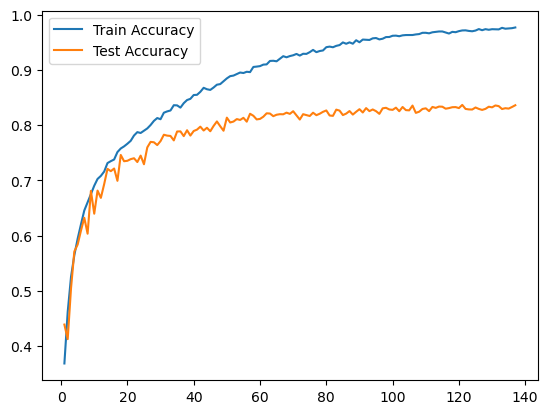

In [25]:
print(train_acc_list)
print(val_acc_list)
print(curr_epoch)
x = np.linspace(1,curr_epoch,curr_epoch)
plt.plot(x, train_acc_list, label = "Train Accuracy")
plt.plot(x, val_acc_list, label = "Test Accuracy")
plt.legend()


Evaluate test accuracy

In [26]:
model.eval()
test_acc = 0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    accuracy = (torch.max(predictions, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
    test_acc += accuracy.item()
test_acc /= len(test_loader)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.835
